In [178]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm


In [239]:
class NVAE(nn.Module):
    def __init__(self, hidden_size=16):
        super().__init__()
        self.hidden_size = hidden_size
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 512),
                                     nn.ReLU(),
                                     nn.Linear(512, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, hidden_size)
                                     )
        self.decoder = nn.Sequential(nn.Linear(hidden_size, 64),
                                     nn.ReLU(),
                                     nn.Linear(64, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 512),
                                     nn.ReLU(),
                                     nn.Linear(512, 28 * 28))

    def forward(self, X):
        bs = X.shape[0]
        h = self.encoder(X.view(bs, -1))
        # return torch.sigmoid(self.decoder(torch.sigmoid(h.view(bs, self.hidden_size)))),h
        return self.decoder(torch.sigmoid(h.view(bs, self.hidden_size))).view(bs, 1, 28, 28), h

    def sample(self, Z):
        return self.decoder(Z)

In [240]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [241]:
model = NVAE(2).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

transform = transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

In [242]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda')
            optimizer.zero_grad()
            output, _ = model(data)
            reconLoss = L2Loss(output.view(-1, 1, 28, 28), data)
            loss = reconLoss
            loss.backward()
            optimizer.step()
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tReconstruction Loss: {:.8f}\t lr: {:.8f}'.format(
                epoch, reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allReconLoss

In [292]:
for epoch in range(1, 1001):
    loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 75%|███████▍  | 44/59 [00:03<00:01, 11.75batch/s,  Epoch: 278 	Reconstruction Loss: 0.03533678	 lr: 0.00000001]


KeyboardInterrupt: 

In [361]:
torch.save(model.state_dict(), '2latent100gird_output')

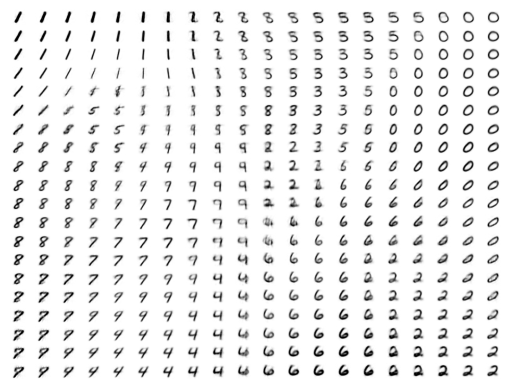

In [371]:
z = torch.zeros((400, 2), dtype=torch.float32, device='cuda')
for i in range(20):
    for j in range(20):
        z[i + j * 20][0] = i * 0.05 + 0.025
        z[i + j * 20][1] = j * 0.05 + 0.025

out_Z = model.sample(z).cpu().detach().view(20, 20, 28, 28).clip_(0, 1)
f, axarr = plt.subplots(20, 20)
for i in range(20):
    for j in range(20):
        axarr[i, j].axis("off")
        axarr[i, j].imshow(out_Z[i][j], cmap='Greys')

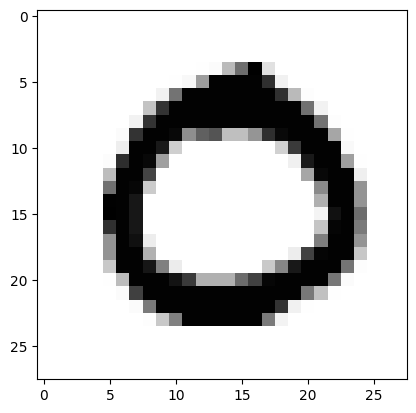

In [342]:
img0 = next(iter(train_loader))[0]
plt.imshow(img0[0][0], cmap='Greys')

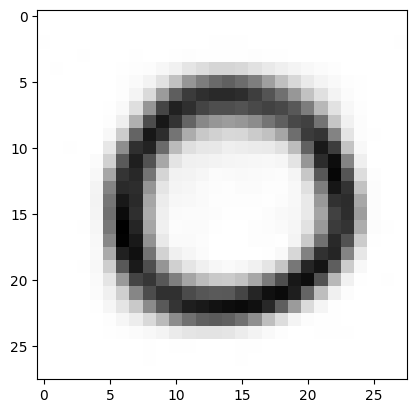

In [343]:
output = model(img0.cuda())
plt.imshow(output[0][0].cpu().detach().view(28, 28).clip_(0, 1), cmap='Greys')

In [346]:
output[1].shape

torch.Size([1024, 2])

In [352]:
torch.sigmoid(output[1][:, 0]).min()

tensor(0.0325, device='cuda:0', grad_fn=<MinBackward1>)

In [353]:
torch.sigmoid(output[1][:, 0]).max()

tensor(0.9943, device='cuda:0', grad_fn=<MaxBackward1>)

In [354]:
torch.sigmoid(output[1][:, 1]).min()

tensor(0.0144, device='cuda:0', grad_fn=<MinBackward1>)

In [355]:
torch.sigmoid(output[1][:, 1]).max()

tensor(0.9923, device='cuda:0', grad_fn=<MaxBackward1>)